In [420]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [421]:
#raw_df = pd.read_csv('./generalAccuracy_combined.csv.bz2', index_col=0)

#raw_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_basicMethods_evaluated_iter500.csv')
#GNN_df = pd.read_csv('./data/imdb-wiki_results/IMDB-WIKI_GNNRank_evaluated.csv')
#raw_df = pd.concat([raw_df, GNN_df[GNN_df.trial != 6]])  # something's off in trial 6?!

raw_df = pd.read_csv('./data/post_processing/EPIRA_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/EPIRA99_10trials.csv')
#raw_df = pd.read_csv('./data/post_processing/FAstarIR_10trials.csv')

#raw_df['bias_applied'] = True
raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})

raw_df

,trial,iteration,value,bias_applied,sampling method,Ranking Method,metric,group
0,0,40,0.311899,False,RandomSampling,davidScore,tau,Overall
1,0,40,0.321771,False,RandomSampling,davidScore,tau,Privileged
2,0,40,0.300553,False,RandomSampling,davidScore,tau,Unprivileged
3,0,40,0.341602,False,RandomSampling,davidScore,tau,Privileged within-group
4,0,40,0.310816,False,RandomSampling,davidScore,tau,Between groups
...,...,...,...,...,...,...,...,...
185835,9,1000,0.063719,True,RankSampling,GNNRank,tau,Privileged within-group
185836,9,1000,0.411647,True,RankSampling,GNNRank,tau,Between groups
185837,9,1000,0.239984,True,RankSampling,GNNRank,tau,Unprivileged within-group
185838,9,1000,0.155690,True,RankSampling,GNNRank,exposure,Privileged


In [422]:
sel_df = raw_df[raw_df.iteration == 500]
sel_df = sel_df.groupby(['iteration','bias_applied','sampling method','metric','group','Ranking Method']).mean().reset_index()
sel_df.loc[sel_df.metric == 'exposure', 'exposure'] = sel_df.value
sel_df.loc[sel_df.metric == 'tau', 'tau'] = sel_df.value
sel_df

,iteration,bias_applied,sampling method,metric,group,Ranking Method,trial,value,exposure,tau
0,500,False,OversampleMinority,exposure,Privileged,GNNRank,4.5,0.148046,0.148046,NaN
1,500,False,OversampleMinority,exposure,Privileged,davidScore,4.5,0.140709,0.140709,NaN
2,500,False,OversampleMinority,exposure,Privileged,randomRankRecovery,4.5,0.147814,0.147814,NaN
3,500,False,OversampleMinority,exposure,Privileged,rankCentrality,4.5,0.140728,0.140728,NaN
4,500,False,OversampleMinority,exposure,Unprivileged,GNNRank,4.5,0.148014,0.148014,NaN
...,...,...,...,...,...,...,...,...,...,...
187,500,True,RankSampling,tau,Unprivileged,rankCentrality,4.5,0.436880,NaN,0.436880
188,500,True,RankSampling,tau,Unprivileged within-group,GNNRank,4.5,0.282014,NaN,0.282014
189,500,True,RankSampling,tau,Unprivileged within-group,davidScore,4.5,0.458943,NaN,0.458943
190,500,True,RankSampling,tau,Unprivileged within-group,randomRankRecovery,4.5,0.718686,NaN,0.718686


In [423]:
priv_df = sel_df[sel_df.group == 'Privileged'].drop(columns=['iteration', 'trial', 'value'])
unpriv_df = sel_df[sel_df.group == 'Unprivileged'].drop(columns=['iteration', 'trial', 'value'])
priv_df

,bias_applied,sampling method,metric,group,Ranking Method,exposure,tau
0,False,OversampleMinority,exposure,Privileged,GNNRank,0.148046,NaN
1,False,OversampleMinority,exposure,Privileged,davidScore,0.140709,NaN
2,False,OversampleMinority,exposure,Privileged,randomRankRecovery,0.147814,NaN
3,False,OversampleMinority,exposure,Privileged,rankCentrality,0.140728,NaN
16,False,OversampleMinority,tau,Privileged,GNNRank,NaN,0.083236
17,False,OversampleMinority,tau,Privileged,davidScore,NaN,0.139796
18,False,OversampleMinority,tau,Privileged,randomRankRecovery,NaN,0.709338
19,False,OversampleMinority,tau,Privileged,rankCentrality,NaN,0.142429
32,False,RandomSampling,exposure,Privileged,GNNRank,0.146874,NaN
33,False,RandomSampling,exposure,Privileged,davidScore,0.147207,NaN


In [424]:
ratio_df = pd.merge(left=priv_df, left_on=['bias_applied','sampling method','metric','Ranking Method'],
                    right=unpriv_df, right_on=['bias_applied','sampling method','metric','Ranking Method'],
                    suffixes=('_priv', '_unpriv'))
ratio_df = ratio_df.drop(columns=['group_priv', 'group_unpriv'])
ratio_df['exposure ratio'] = ratio_df.exposure_unpriv / ratio_df.exposure_priv  # higher is better
ratio_df['error ratio'] = ratio_df.tau_priv / ratio_df.tau_unpriv  # lower is better
ratio_df

,bias_applied,sampling method,metric,Ranking Method,exposure_priv,tau_priv,exposure_unpriv,tau_unpriv,exposure ratio,error ratio
0,False,OversampleMinority,exposure,GNNRank,0.148046,NaN,0.148014,NaN,0.999779,NaN
1,False,OversampleMinority,exposure,davidScore,0.140709,NaN,0.155351,NaN,1.104060,NaN
2,False,OversampleMinority,exposure,randomRankRecovery,0.147814,NaN,0.148246,NaN,1.002923,NaN
3,False,OversampleMinority,exposure,rankCentrality,0.140728,NaN,0.155333,NaN,1.103782,NaN
4,False,OversampleMinority,tau,GNNRank,NaN,0.083236,NaN,0.067127,NaN,1.239992
5,False,OversampleMinority,tau,davidScore,NaN,0.139796,NaN,0.128599,NaN,1.087070
6,False,OversampleMinority,tau,randomRankRecovery,NaN,0.709338,NaN,0.701380,NaN,1.011345
7,False,OversampleMinority,tau,rankCentrality,NaN,0.142429,NaN,0.131688,NaN,1.081560
8,False,RandomSampling,exposure,GNNRank,0.146874,NaN,0.149186,NaN,1.015741,NaN
9,False,RandomSampling,exposure,davidScore,0.147207,NaN,0.148854,NaN,1.011188,NaN


In [425]:
exp_df = ratio_df[ratio_df.metric == 'exposure']
tau_df = ratio_df[ratio_df.metric == 'tau']

overall_df = pd.merge(left=exp_df[['bias_applied','sampling method','Ranking Method', 'exposure ratio']],
                      left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_df[['bias_applied','sampling method','Ranking Method', 'error ratio']],
                      right_on=['bias_applied','sampling method','Ranking Method'])

tau_overall_df = sel_df[sel_df.group == 'Overall'].drop(columns=['iteration', 'metric', 'group', 'trial', 'exposure', 'value']).rename(columns={'tau': 'error'})
overall_df = pd.merge(left=overall_df, left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_overall_df, right_on=['bias_applied','sampling method','Ranking Method'])

overall_df

,bias_applied,sampling method,Ranking Method,exposure ratio,error ratio,error
0,False,OversampleMinority,GNNRank,0.999779,1.239992,0.075961
1,False,OversampleMinority,davidScore,1.104060,1.087070,0.123197
2,False,OversampleMinority,randomRankRecovery,1.002923,1.011345,0.705539
3,False,OversampleMinority,rankCentrality,1.103782,1.081560,0.126307
4,False,RandomSampling,GNNRank,1.015741,1.006022,0.061999
5,False,RandomSampling,davidScore,1.011188,0.977486,0.063574
6,False,RandomSampling,randomRankRecovery,0.988468,0.994036,0.710728
7,False,RandomSampling,rankCentrality,1.013964,0.999322,0.067029
8,False,RankSampling,GNNRank,0.999450,0.986200,0.151714
9,False,RankSampling,davidScore,0.989932,0.969728,0.249932


In [426]:
overall_df = overall_df.replace({'OversampleMinority': 'Oversampling',
                                 'oversampling': 'Oversampling',
                                 'RankSampling': 'Rank-Based Sampling',
                                 'rankSampling': 'Rank-Based Sampling',
                                 'RandomSampling': 'Random Sampling',
                                 'randomSampling': 'Random Sampling',
                                 'fairPageRank': 'Fairness-Aware PageRank',
                                 'davidScore': "David's Score",
                                 'randomRankRecovery': 'Random Rank Recovery',
                                 'rankCentrality': 'Rank Centrality'})

overall_df = overall_df.rename(columns={'sampling method': 'Sampling Method'})

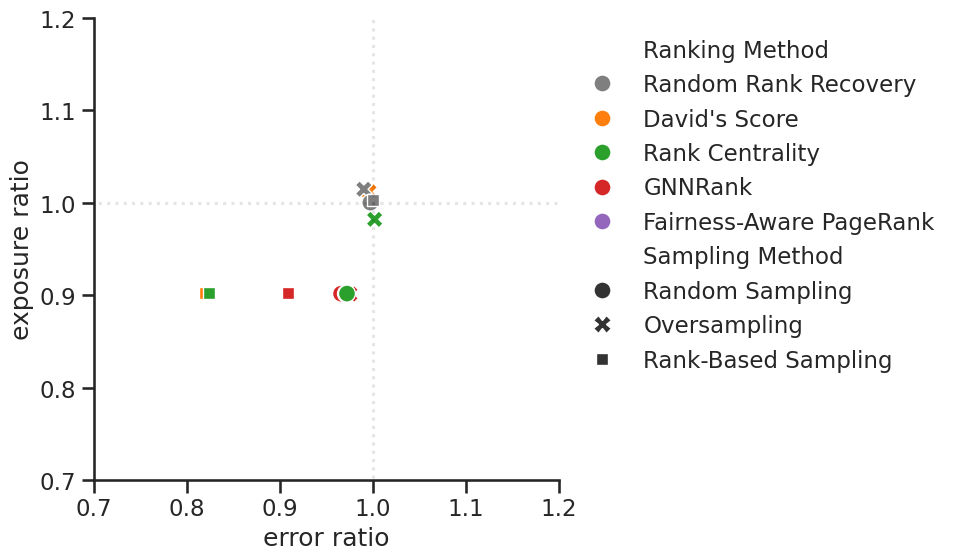

In [427]:
palette = sns.color_palette('tab10')
palette[0] = palette[7]
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = overall_df[(overall_df.bias_applied)].copy()# & (overall_df['Sampling Method'] == 'Random Sampling')]
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling']
df = df[df['Ranking Method'].isin(ranking_methods)]
#df['exposure ratio'] = df['exposure ratio'] + np.random.normal(0,0.001,len(df))
#df['error ratio'] = df['error ratio'] + np.random.normal(0,0.001,len(df))
#df['error'] = df['error'] + np.random.normal(0,0.001,len(df))

with sns.color_palette(palette):
    ax = sns.scatterplot(df, x='error ratio', y='exposure ratio', hue='Ranking Method', s=150, style='Sampling Method',
                         hue_order=['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank'],
                         style_order=['Random Sampling', 'Oversampling', 'Rank-Based Sampling'])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(xlim=(0.7,1.2), ylim=(0.7,1.2))
plt.plot([0,2], [1,1], color='black', linestyle='dotted', alpha=0.1)
plt.plot([1,1], [0,2], color='black', linestyle='dotted', alpha=0.1)
sns.despine()

## Seperate 1D Plots

In [428]:
sel_df2 = raw_df[(raw_df.iteration == 500) & raw_df.bias_applied].drop(columns=['iteration', 'bias_applied'])
sel_df2 = sel_df2.pivot(index=['trial', 'sampling method', 'Ranking Method'], columns=['metric', 'group'], values='value').reset_index()
sel_df2

metric trial     sampling method      Ranking Method       tau             \
group                                                  Overall Privileged   
0          0  OversampleMinority             GNNRank  0.284713   0.318775   
1          0  OversampleMinority          davidScore  0.276999   0.312786   
2          0  OversampleMinority  randomRankRecovery  0.785360   0.794933   
3          0  OversampleMinority      rankCentrality  0.302307   0.335093   
4          0      RandomSampling             GNNRank  0.288322   0.322601   
..       ...                 ...                 ...       ...        ...   
115        9      RandomSampling      rankCentrality  0.288249   0.310766   
116        9        RankSampling             GNNRank  0.334080   0.342192   
117        9        RankSampling          davidScore  0.429534   0.409453   
118        9        RankSampling  randomRankRecovery  0.705397   0.690912   
119        9        RankSampling      rankCentrality  0.368473   0.345364   

metric                                                      \
group  Unprivileged Privileged within-group Between groups   
0          0.318342                0.116724       0.377175   
1          0.302866                0.160100       0.361190   
2          0.775744                0.814794       0.785181   
3          0.339370                0.136172       0.397883   
4          0.329334                0.070945       0.390620   
..              ...                     ...            ...   
115        0.332242                0.072704       0.379459   
116        0.395609                0.074139       0.428239   
117        0.475408                0.162321       0.475792   
118        0.720139                0.661676       0.705644   
119        0.416993                0.148007       0.409943   

metric                             exposure               
group  Unprivileged within-group Privileged Unprivileged  
0                       0.158072   0.155722     0.140339  
1                       0.141077   0.143840     0.152220  
2                       0.756968   0.148934     0.147126  
3                       0.171876   0.146943     0.149118  
4                       0.148221   0.155597     0.140464  
..                           ...        ...          ...  
115                     0.201058   0.155750     0.140310  
116                     0.299941   0.155774     0.140286  
117                     0.474748   0.155617     0.140443  
118                     0.749455   0.144679     0.151381  
119                     0.430837   0.155645     0.140416  

[120 rows x 11 columns]

In [429]:
sel_df3 = sel_df2.copy()
sel_df3['exposure ratio'] = sel_df3['exposure']['Unprivileged'] / sel_df3['exposure']['Privileged']
sel_df3['error ratio'] = sel_df3['tau']['Unprivileged'] / sel_df3['tau']['Privileged']
sel_df3['error'] = sel_df3['tau']['Overall']
sel_df3 = sel_df3[['trial', 'sampling method', 'Ranking Method', 'exposure ratio', 'error ratio', 'error']].droplevel('group', axis=1)
sel_df3 = sel_df3.replace({'OversampleMinority': 'Oversampling',
                            'oversampling': 'Oversampling',
                            'RankSampling': 'Rank-Based Sampling',
                            'rankSampling': 'Rank-Based Sampling',
                            'RandomSampling': 'Random Sampling',
                            'randomSampling': 'Random Sampling',
                            'fairPageRank': 'Fairness-Aware PageRank',
                            'davidScore': "David's Score",
                            'randomRankRecovery': 'Random Rank Recovery',
                            'rankCentrality': 'Rank Centrality'})

sel_df3 = sel_df3.rename(columns={'sampling method': 'Sampling Method'})
sel_df3

metric,trial,Sampling Method,Ranking Method,exposure ratio,error ratio,error
0,0,Oversampling,GNNRank,0.901214,0.998642,0.284713
1,0,Oversampling,David's Score,1.058260,0.968285,0.276999
2,0,Oversampling,Random Rank Recovery,0.987862,0.975861,0.785360
3,0,Oversampling,Rank Centrality,1.014800,1.012764,0.302307
4,0,Random Sampling,GNNRank,0.902741,1.020871,0.288322
...,...,...,...,...,...,...
115,9,Random Sampling,Rank Centrality,0.900863,1.069107,0.288249
116,9,Rank-Based Sampling,GNNRank,0.900576,1.156103,0.334080
117,9,Rank-Based Sampling,David's Score,0.902487,1.161079,0.429534
118,9,Rank-Based Sampling,Random Rank Recovery,1.046326,1.042303,0.705397


In [430]:
# Okabe-Ito color palette
lightblue = "#56B4E9"
yellow = "#F0E442"
orange = "#E69F00"
green = "#009E73"
purple = "#CC79A7"
red = "#D55E00"
blue = "#0072B2"
black = "#000000"
palette = [black, orange, lightblue, green, yellow, blue, red, purple]

palette = sns.color_palette('tab10')
#palette[0] = palette[7]

sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = sel_df3
ranking_methods = ['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank']
sampling_methods = ['Random Sampling', 'Oversampling', 'Rank-Based Sampling']
metrics = ['exposure ratio', 'error ratio', 'error']

df = df[df['Ranking Method'].isin(ranking_methods)]
df = df.melt(id_vars=['Sampling Method', 'Ranking Method'], value_vars=['exposure ratio', 'error ratio', 'error'])

df['metric_order'] = df.metric.map(metrics.index)
df['sampling_order'] = df['Sampling Method'].map(sampling_methods.index)
df['ranking_order'] = df['Ranking Method'].map(list(reversed(ranking_methods)).index)
df = df.sort_values(by=['ranking_order', 'sampling_order', 'metric_order']).drop(columns=['ranking_order', 'sampling_order', 'metric_order'])

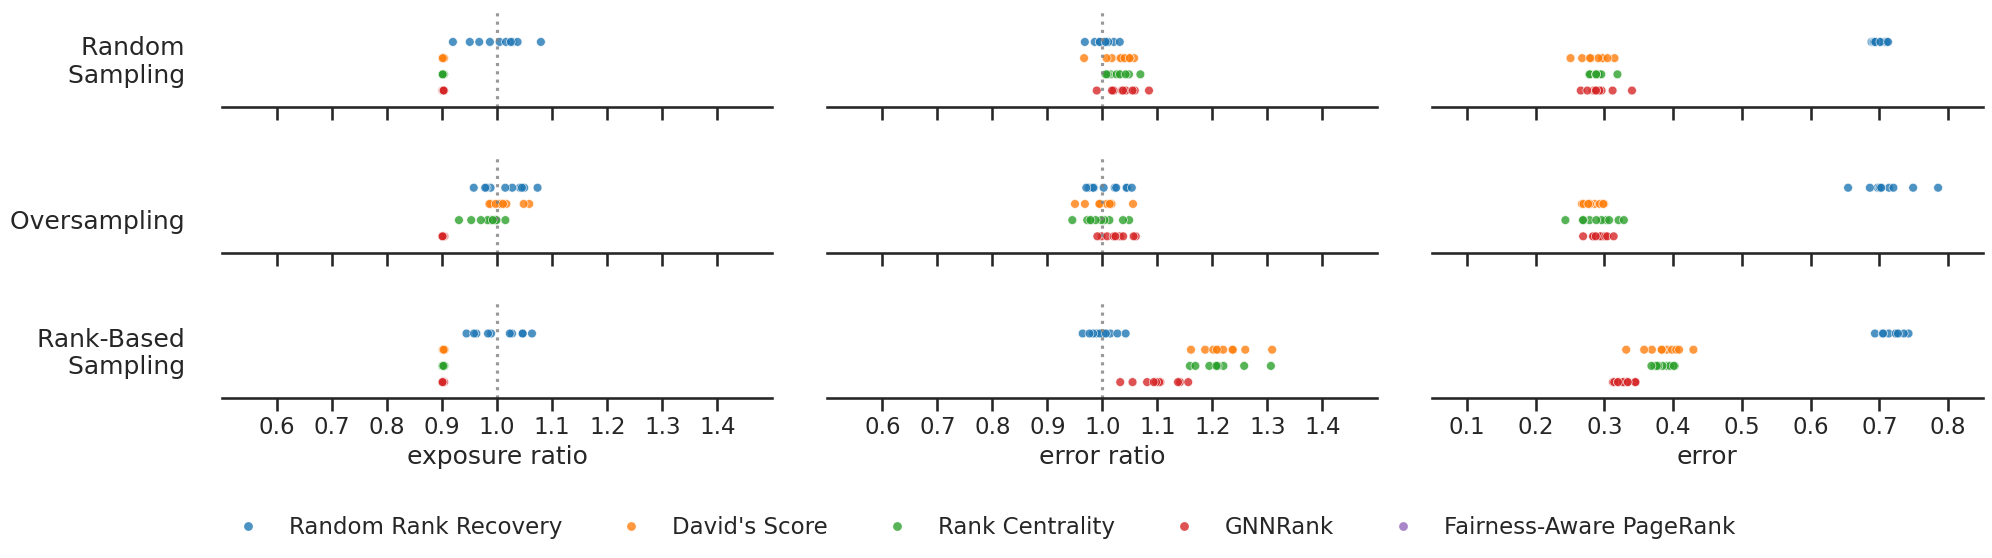

In [431]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.relplot(df, x='value', y='Ranking Method', hue='Ranking Method', kind='scatter', #style='Sampling Method',
                    row='Sampling Method', col='metric',
                    hue_order=ranking_methods, style_order=sampling_methods,
                    s=40, alpha=0.8, aspect=4/1, height=1.8, facet_kws={'sharey': True, 'sharex': False})

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.13, 0))#
g.refline(x=1, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((-1,5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(0.5,1.5))
        ax.set_xticks([.6,.7,.8,.9,1,1.1,1.2,1.3,1.4])
    
    if col_val == 'exposure ratio':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)

sns.despine(left=True)
#plt.savefig('./data/others_results/combined_results_1D.png', dpi=300, bbox_inches="tight")

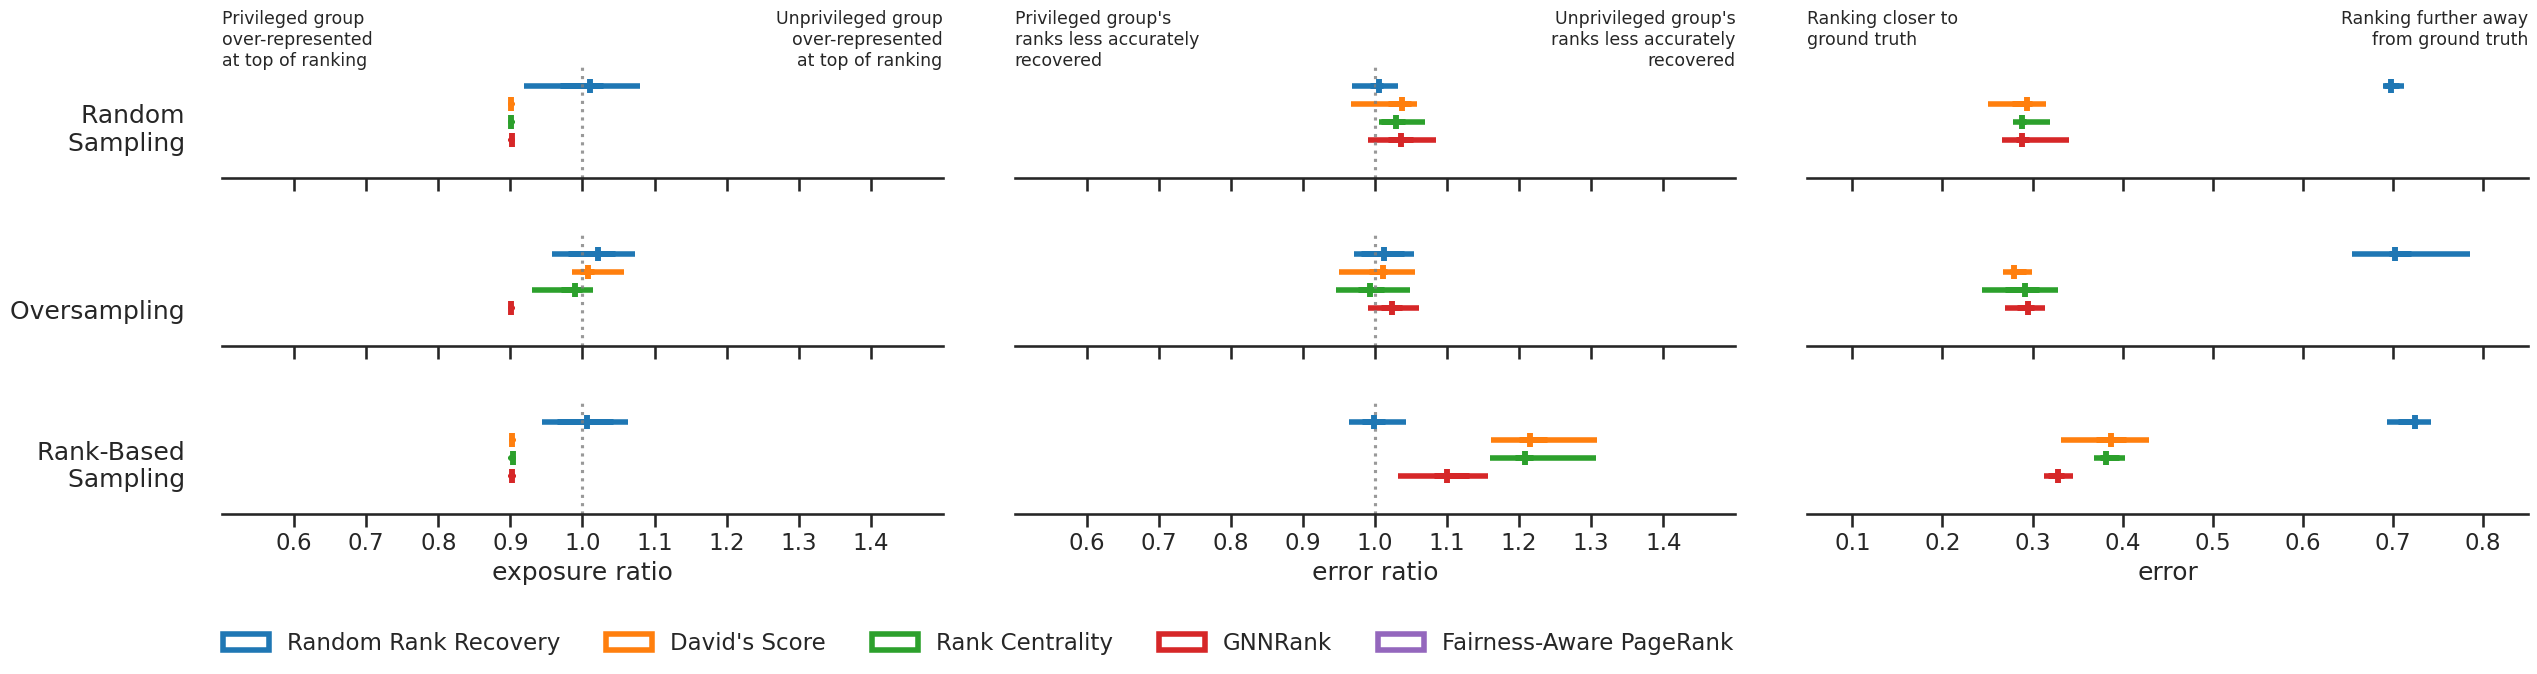

In [432]:
with sns.color_palette(palette):
    #g = sns.FacetGrid(df, row='Sampling Method', col='metric',
    #                  margin_titles=True)
    #g.map_dataframe(sns.pointplot, x='value', y='Ranking Method', hue='Ranking Method')
    g = sns.catplot(df, x='value', kind='box', #style='Sampling Method',
                    row='Sampling Method', col='metric', hue='Ranking Method',
                    hue_order=ranking_methods, sharex=False, sharey=True,
                    aspect=4/1, height=2,
                    # sns.boxplot properties
                    fill=False, whis=100, linewidth=4,
                    # plt.boxplot properties & Line2D properties
                    medianprops={'marker': '|', 'markeredgewidth': 4, 'markersize': 10}, showcaps=False,
                    #showmeans=True, meanprops={'marker': '|', 'markeredgecolor': 'black', 'markeredgewidth': 2, 'markersize': 10},
                    widths=0)
    # s=40, alpha=0.8, facet_kws={'sharey': True, 'sharex': False}, height=1.8

sns.move_legend(g, 'upper left', ncol=5, title=None, bbox_to_anchor=(0.007, 0))

g.refline(x=1, linestyle='dotted', alpha=0.8)
g.figure.subplots_adjust(wspace=0.1, hspace=0.5)

for (row_val, col_val), ax in g.axes_dict.items():
    ax.set_title(None)
    ax.set_yticks([-100])
    ax.set_ylim((0.5,-0.5))
    
    if row_val == 'Rank-Based Sampling':
        ax.set_xlabel(col_val)
    else:
        ax.set_xticklabels([])

    if col_val == 'error':
        ax.set(xlim=(0.05,0.85))
        ax.set_xticks([.1,.2,.3,.4,.5,.6,.7,.8])
    else:
        ax.set(xlim=(0.5,1.5))
        ax.set_xticks([.6,.7,.8,.9,1,1.1,1.2,1.3,1.4])
    
    if col_val == 'exposure ratio':
        ax.set_ylabel('    \n'.join(row_val.split()) + '    ', rotation=0, horizontalalignment='right', y=0.2)
    
    if row_val == 'Random Sampling':
        y = -0.5
        y_offset = -.5
        if col_val == 'exposure ratio':
            ax.annotate('Privileged group\nover-represented\nat top of ranking',
                        xy=(0.5, y), xytext=(0.5,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\nover-represented\nat top of ranking',
                        xy=(1.5, y), xytext=(1.5,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error ratio':
            ax.annotate('Privileged group\'s\nranks less accurately\nrecovered',
                        xy=(0.5, y), xytext=(0.5,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Unprivileged group\'s\nranks less accurately\nrecovered',
                        xy=(1.5, y), xytext=(1.5,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')
        elif col_val == 'error':
            ax.annotate('Ranking closer to\nground truth',
                        xy=(0.05, y), xytext=(0.05,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small')
            ax.annotate('Ranking further away\nfrom ground truth',
                        xy=(.85, y), xytext=(0.85,y+y_offset), horizontalalignment='right', verticalalignment='top', fontsize='x-small')

sns.despine(left=True)
plt.savefig('./data/others_results/EPIRA_results_1D_V2.png', dpi=300, bbox_inches="tight")